In [203]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
#df=pd.read_excel('restaurants.xlsx')

In [204]:
#df = pd.read_excel('restaurant_info_6Districts_Ju.xlsx')
df = pd.read_excel('FinalProject/REST_Analysis_JAPANESE.xlsx')

In [205]:
pd.set_option('display.max_columns',40,'display.max_rows',40)

In [206]:
#fit notebook cell to browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<h1>DATA CLEAN

In [207]:
#remove asia miles
asia_miles_index = df[df['food_type'].str.contains("eligible transactions")].index
df= df.drop(asia_miles_index)
df = df.reset_index()
df = df.drop('index',axis=1)

In [208]:
#drop duplicate entries with same name and location
df.drop_duplicates(subset=['name', 'location'], keep='last',inplace = True)

In [209]:
#change columns to float type
df['happy'] = df['happy'].astype(float)
df['sad'] = df['sad'].astype(float)
df['bookmark'] = df['bookmark'].astype(float)

In [210]:
#insert additional column of pure numeric prices
df['price_int'] = df['price'].replace({"Below $50":25,"$51-100":75,"$101-200":150,"$201-400":300,"$401-800":600,"Above $801":1000})

In [211]:
#define locations
Places = ['Causeway Bay','Central',"Yuen Long","Tsuen Wan","Tsim Sha Tsui","Mong Kok"]

In [212]:
#give location type a number
location_model = OrdinalEncoder()
test = pd.DataFrame(location_model.fit_transform(df[['location']]))

df = pd.concat([df,test],axis=1,join='inner')
df = df.rename(columns={0:"location_int"})
df.shape

(1340, 19)

In [213]:
#introduce happy vs sad column
df['happy_vs_sad'] = df['happy']/df['sad']
df['happy_vs_sad'] = np.where(df['happy_vs_sad'] == np.inf, df['happy'], df['happy_vs_sad'])


In [214]:
#df only has Japanese food left
df = df[df['food_type']=="Japanese"]

In [215]:
#find number of payment and facilities
df['num_payment'] = df['pay_list'].str.count(',')+1
df['num_facility'] = df['other_facility'].str.count(',')+1

In [216]:
#get list of payment methods
df['payment_methods'] = df['pay_list'].str.split(',')
df.reset_index(inplace=True, drop = True)

In [217]:
#categorically split payment methods
one_hot = pd.get_dummies(df['payment_methods'].apply(pd.Series).stack()).sum(level=0)
df = df.merge(one_hot,how='outer',left_index = True, right_index=True)

In [218]:
#ignore all payment methods who are not in more than 20% of restaurants
arr_keep = ['name','price','food_type','location','other_facility','pay_list']
for i,j in list((df.describe().iloc[1]>0.2).items()):
    if j:
        arr_keep.append(i)
df = df[arr_keep]

In [219]:
#group locations to their respective district
def district(x):
    if x == "Causeway Bay" or x == "Central":
        return "HK"
    if x == "Yuen Long" or x == "Tsuen Wan":
        return "NT"
    else:
        return "KL"
    
df['location'] = df['location'].apply(lambda x: district(x))

<h1>USEFUL VISUALIZATION TOOLS

In [220]:
def bar_chart(column,x_axis = "variables",title = "graph of X",y_axis = "number of X"): #draws bar chart, input one array
    x = column.value_counts(sort=False).index
    y = column.value_counts(sort=False)

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(x, y, color ='orange',
            width = 0.4)

    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.show()

In [221]:
def scatter_graph(x,y,title): #draws a scatter graph, input two arrays
    m, b = np.polyfit(x, y, 1)
    print("y intercept: ", b, "slope: ",m)
    plt.scatter(x, y, alpha=0.7)
    try:
        plt.plot(x, m*x + b)
    except:
        None
        
    try:
        #plt.title("{} vs {}".format(y.name, x.name))
        plt.xlabel(x.name)
        plt.ylabel(y.name)
    except:
        #plt.title("Title")
        plt.xlabel("X-Axis")
        plt.ylabel("Y-Axis")
    plt.title(title)
    plt.show()
    

In [222]:
def scatter_graph_2(x,y,title,size ):
    #draws a scatter graph with poly regression, input two arrays
    p2 = np.polyfit(x, y, 3)
    
    plt.scatter(x, y, alpha=0.7)
    
    xp=np.linspace(0,size,200)
    plt.plot(xp, np.polyval(p2,xp))
   
    try:
        #plt.title("{} vs {}".format(y.name, x.name))
        plt.xlabel(x.name)
        plt.ylabel(y.name)
    except:
        #plt.title("Title")
        plt.xlabel("X-Axis")
        plt.ylabel("Y-Axis")
    plt.title(title)
    plt.show()
    

In [223]:
def find_average(df): #returns sad, happy, bookmark, price_int
    print("Average sad is: ",df['sad'].mean())
    print("Average happy is: ",df['happy'].mean())
    print("Average bookmark is: ",df['bookmark'].mean())
    print("Average price is: ",df['price_int'].mean())
    print("------------------ \n")
    return df['sad'].mean(),df['happy'].mean(),df['bookmark'].mean(),df['price_int'].mean()

In [224]:
def scatter_matrix(df,columns = ['price','bookmark','happy','sad','happy_vs_sad'], dot_size = 30, fig_size = (20,20)):
    visual = pd.plotting.scatter_matrix(df[columns],marker = 'o', s=dot_size,  figsize=fig_size)

In [225]:
def color_scatter_matrix(df,food_or_loc,  columns = ['location_int','price_int','bookmark','happy','sad'], dot_size = 30, fig_size = (20,20)):
     
    if food_or_loc == 'food':
        visual = pd.plotting.scatter_matrix(df[columns],marker = 'o', c=df['food_int'] , s=dot_size,  figsize=fig_size)
        
    
    else: 
        visual = pd.plotting.scatter_matrix(df[columns],marker = 'o', c=df['location_int'] , s=dot_size,  figsize=fig_size)


In [226]:
def legend(food_loc): #finds legend for color_scatter_matrix

    if food_loc == 'food':
        base_tags = pd.DataFrame(list(range(df['food_int'].nunique())))
        plt.imshow([np.unique(df['food_int'])])
        plt.xticks(ticks=np.unique(df['food_int']),labels=food_model.inverse_transform(base_tags))
    else:
        base_tags = pd.DataFrame(list(range(df['location_int'].nunique())))
        plt.imshow([np.unique(df['location_int'])])
        plt.xticks(ticks=np.unique(df['location_int']),labels=location_model.inverse_transform(base_tags))

In [227]:
def density_graph(a,b,df):
    sns.jointplot(a, b, 
              data=df, kind="kde")
    plt.show()
    
def scatter_bar(a,b,df):
    sns.jointplot(a, b, 
              data=df, kind="reg")
    plt.show()

In [228]:
def pair_plot(df,variable):
    sns.pairplot(df, hue=variable, height=1.8)
    
    plt.show()

<h1> Conduct Analysis

## Additional options

<h2>Location

In [185]:
#used in location popularity
df.groupby('location').describe()

bookmark                                                       \
            count          mean           std     min     25%      50%   
location                                                                 
HK          117.0  14415.188034   8701.468334  2129.0  8977.0  11815.0   
KL          111.0  17119.288288  14130.542042  2028.0  7713.5  12664.0   
NT          102.0   5397.490196   5525.806746   384.0  1946.0   3497.5   

                            happy                                        \
              75%      max  count        mean         std   min     25%   
location                                                                  
HK        18321.0  45755.0  117.0  228.598291  209.282974  24.0   76.00   
KL        20940.0  86010.0  111.0  300.567568  204.929949  57.0  138.00   
NT         6987.5  30518.0  102.0  129.009804  126.874265   3.0   47.75   

                                  sad                             ... Master  \
            50%    75%     max  count       mean        std  min  ...    25%   
location                                                          ...          
HK        141.0  328.0  1065.0  117.0   9.931624  12.378183  0.0  ...    1.0   
KL        219.0  457.5   895.0  111.0  18.873874  25.606149  0.0  ...    1.0   
NT         76.5  161.0   656.0  102.0   8.392157  12.224109  0.0  ...    0.0   

                        UnionPay                                               \
          50%  75%  max    count      mean       std  min  25%  50%  75%  max   
location                                                                        
HK        1.0  1.0  1.0    117.0  0.683761  0.467008  0.0  0.0  1.0  1.0  1.0   
KL        1.0  1.0  1.0    110.0  0.672727  0.471365  0.0  0.0  1.0  1.0  1.0   
NT        1.0  1.0  1.0     97.0  0.391753  0.490678  0.0  0.0  0.0  1.0  1.0   

           Visa                                               
          count      mean       std  min  25%  50%  75%  max  
location                                                      
HK        117.0  0.888889  0.315621  0.0  1.0  1.0  1.0  1.0  
KL        110.0  0.836364  0.371638  0.0  1.0  1.0  1.0  1.0  
NT         97.0  0.639175  0.482735  0.0  0.0  1.0  1.0  1.0  

[3 rows x 176 columns]

In [186]:
#filter only HK island for analysis
df = df[df['location'] == "HK"]

<h2> Price

In [187]:
#used in price analysis
df.groupby('price').describe()

bookmark                                                          \
              count          mean           std      min       25%      50%   
price                                                                         
$101-200       30.0  10879.966667   6780.444307   2129.0   5383.50  10428.0   
$201-400       34.0  17823.470588   9509.739557   4633.0  11629.75  14786.5   
$401-800       16.0  15791.125000   6942.578866   6665.0  10633.75  14606.5   
$51-100        19.0  13761.105263  10000.204470   2416.0   7819.50  10741.0   
Above $801     17.0  11700.058824   4282.249445   3304.0  10119.00  11075.0   
Below $50       1.0  41160.000000           NaN  41160.0  41160.00  41160.0   

                              happy                                         \
                 75%      max count        mean         std    min     25%   
price                                                                        
$101-200    13746.00  27314.0  30.0  200.566667  156.360698   53.0   84.25   
$201-400    24987.00  45755.0  34.0  297.176471  250.114334   31.0   87.00   
$401-800    20305.25  28675.0  16.0  178.437500  165.567698   33.0   72.50   
$51-100     16571.50  38296.0  19.0  225.684211  134.512309   33.0  131.00   
Above $801  13017.00  24289.0  17.0  166.647059  262.747251   24.0   43.00   
Below $50   41160.00  41160.0   1.0  649.000000         NaN  649.0  649.00   

                                    sad                              ...  \
              50%     75%     max count       mean        std   min  ...   
price                                                                ...   
$101-200    138.5  295.75   642.0  30.0   8.400000   8.880820   0.0  ...   
$201-400    201.5  452.00   888.0  34.0  10.911765  13.569948   0.0  ...   
$401-800    130.5  235.25   712.0  16.0   8.812500  13.070163   0.0  ...   
$51-100     196.0  306.00   464.0  19.0  14.894737  17.213995   0.0  ...   
Above $801   81.0  111.00  1065.0  17.0   5.764706   6.005512   0.0  ...   
Below $50   649.0  649.00   649.0   1.0  17.000000        NaN  17.0  ...   

           Master                UnionPay                                      \
              25%  50%  75%  max    count      mean       std  min   25%  50%   
price                                                                           
$101-200      1.0  1.0  1.0  1.0     30.0  0.766667  0.430183  0.0  1.00  1.0   
$201-400      1.0  1.0  1.0  1.0     34.0  0.764706  0.430562  0.0  1.00  1.0   
$401-800      1.0  1.0  1.0  1.0     16.0  0.750000  0.447214  0.0  0.75  1.0   
$51-100       0.0  1.0  1.0  1.0     19.0  0.368421  0.495595  0.0  0.00  0.0   
Above $801    1.0  1.0  1.0  1.0     17.0  0.705882  0.469668  0.0  0.00  1.0   
Below $50     0.0  0.0  0.0  0.0      1.0  0.000000       NaN  0.0  0.00  0.0   

                      Visa                                               
            75%  max count      mean       std  min  25%  50%  75%  max  
price                                                                    
$101-200    1.0  1.0  30.0  0.933333  0.253708  0.0  1.0  1.0  1.0  1.0  
$201-400    1.0  1.0  34.0  0.970588  0.171499  0.0  1.0  1.0  1.0  1.0  
$401-800    1.0  1.0  16.0  0.937500  0.250000  0.0  1.0  1.0  1.0  1.0  
$51-100     1.0  1.0  19.0  0.578947  0.507257  0.0  0.0  1.0  1.0  1.0  
Above $801  1.0  1.0  17.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0  
Below $50   0.0  0.0   1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  

[6 rows x 176 columns]

In [229]:
df.describe().iloc[1,16:]


AE          0.395062
Alipay      0.620370
AlipayHK    0.623457
Cash        0.993827
Master      0.793210
UnionPay    0.592593
Visa        0.796296
Name: mean, dtype: float64

<AxesSubplot:xlabel='price_int', ylabel='overall'>

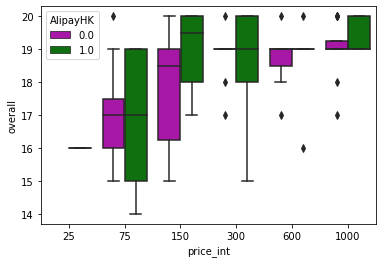

In [194]:
sns.boxplot(x="price_int", y="overall",
            hue="AlipayHK", palette=["m", "g"],
            data=df)

<h2> Payment method

service


NameError: name 'df_pay_200' is not defined

<h2> Number of seats

overall


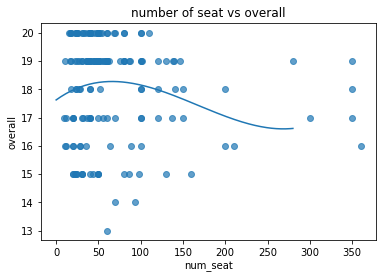

taste


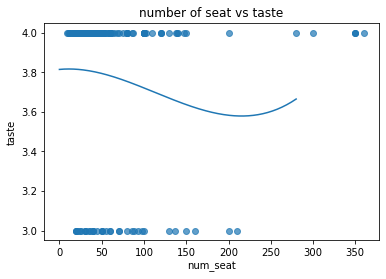

decor


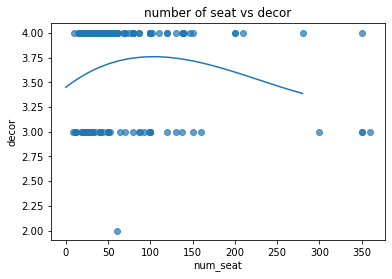

service


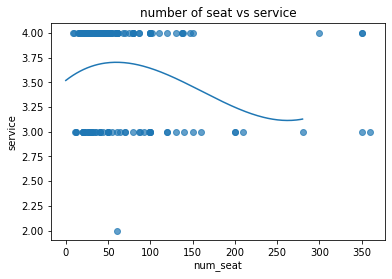

hygiene


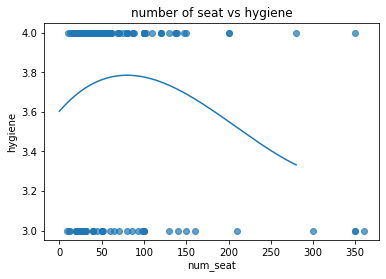

value


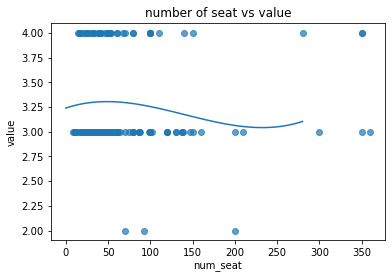

happy


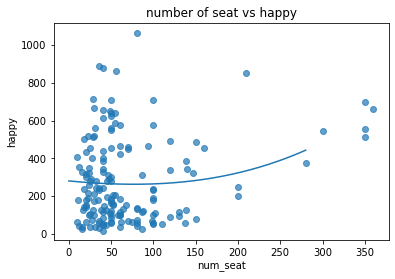

In [237]:
#analysis on effective number of seat can bring customer satisfaction
df_seat=df[df['num_seat'] != 0]
for i in ['overall','taste', 'decor', 'service',  'hygiene', 'value','happy']:
    print(i)
    title = 'number of seat vs '+i
    scatter_graph_2(df_seat['num_seat'],df_seat[i], title,280)
    

<h2> Other facilities

service


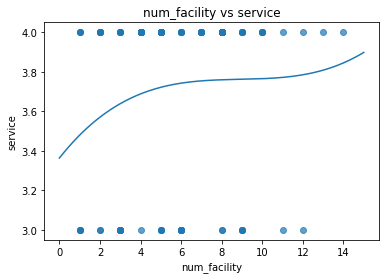

              num_facility   service
num_facility      1.000000  0.156625
service           0.156625  1.000000
value


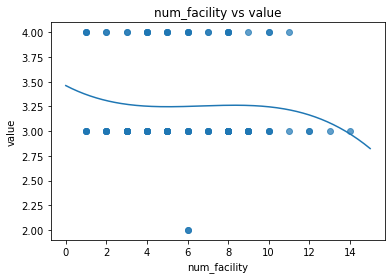

              num_facility     value
num_facility      1.000000 -0.069632
value            -0.069632  1.000000
overall


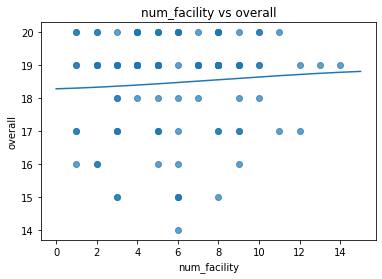

              num_facility   overall
num_facility      1.000000  0.076795
overall           0.076795  1.000000
happy


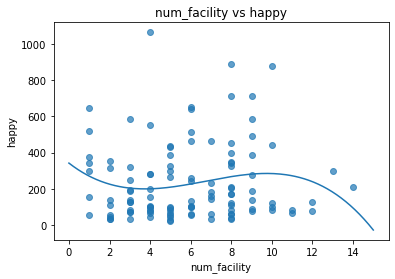

              num_facility     happy
num_facility      1.000000  0.056842
happy             0.056842  1.000000
bookmark


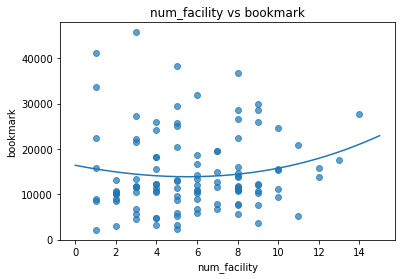

              num_facility  bookmark
num_facility      1.000000  0.054614
bookmark          0.054614  1.000000


In [235]:
# analysis on effect from num_facility to utility rating
df_fac.dropna(inplace=True)
for i in ['service','value','overall','happy','bookmark']: 
    print(i)
    title = 'num_facility vs '+i
    scatter_graph_2(df_fac['num_facility'], df_fac[i], title,15)
    print(df_fac[['num_facility',i]].corr())
    #scatter_bar("num_facility",i,df_fac_HK)


In [236]:
# analysis on effect from specific facility
for j in list(df_fac_all.columns)[14:]:
    print(j)
    grp=df_fac.groupby(j,as_index=True)
    for i in ['service','value','overall','happy','bookmark']:
        print('\n')
        
        print(grp.agg({i:'median'}))
        
    print('\n')
    


10% Service Charge


                    service
10% Service Charge         
0.0                     4.0
1.0                     4.0


                    value
10% Service Charge       
0.0                   4.0
1.0                   3.0


                    overall
10% Service Charge         
0.0                    19.5
1.0                    19.0


                    happy
10% Service Charge       
0.0                 205.0
1.0                 153.0


                    bookmark
10% Service Charge          
0.0                   6317.0
1.0                  12189.0


Accessible Environment


                        service
Accessible Environment         
0.0                         4.0
1.0                         3.0


                        value
Accessible Environment       
0.0                       3.0
1.0                       3.0


                        overall
Accessible Environment         
0.0                        19.0
1.0                        17.0


              

1.0             3.0


              overall
TV Broadcast         
0.0              19.0
1.0              18.0


              happy
TV Broadcast       
0.0           148.5
1.0           466.0


              bookmark
TV Broadcast          
0.0            11718.0
1.0            19621.0


VIP Room


          service
VIP Room         
0.0           4.0
1.0           4.0


          value
VIP Room       
0.0         3.0
1.0         3.0


          overall
VIP Room         
0.0          19.0
1.0          19.0


          happy
VIP Room       
0.0       141.0
1.0       166.0


          bookmark
VIP Room          
0.0        11603.0
1.0        14439.0


Vegetarian


            service
Vegetarian         
0.0             4.0
1.0             3.0


            value
Vegetarian       
0.0           3.0
1.0           3.0


            overall
Vegetarian         
0.0            19.0
1.0            17.0


            happy
Vegetarian       
0.0         154.5
1.0          80.0


            bookma

<h2> Factors that affect overall scores

### Other Facilities

In [38]:
# get dataframe for facility analysis
df_c=df
df_fac=df_c[['name','bookmark','happy','location','taste','decor','service','hygiene','value','overall','happy_vs_sad','num_facility','other_facility']]
df_fac.fillna(0)
#df_fac['location'] = df_fac['location'].apply(lambda x: district(x))
df_fac=df_fac[df_fac['other_facility']!=0]
df_fac['facilities'] = df_fac['other_facility'].str.split(',')
df_fac.reset_index(inplace=True, drop = True)
one_hot = pd.get_dummies(df_fac['facilities'].apply(pd.Series).stack()).sum(level=0)
df_fac = df_fac.merge(one_hot,how='outer',left_index = True, right_index=True)

df_fac.describe()

,bookmark,happy,taste,decor,service,hygiene,value,overall,happy_vs_sad,num_facility,10% Service Charge,Accessible Environment,Alcoholic Drinks,Cake-cutting,Delivery,Eco-Friendly,Exclusive Online Booking,May Bring Your Own Wine,Online Reservation,Open Till Late,Opens 24 Hours,Outdoor Seating,Parking,Phone Reservation,Restaurant Mode of Operation - Type B,Reward Dining Points,Spot payment,TV Broadcast,VIP Room,Vegetarian,Wi-Fi
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.00000,111.000000,111.000000
mean,14415.188034,228.598291,3.863248,3.743590,3.692308,3.863248,3.264957,18.427350,44.033857,5.855856,0.891892,0.009009,0.747748,0.351351,0.396396,0.009009,0.027027,0.477477,0.495495,0.072072,0.009009,0.063063,0.099099,0.594595,0.036036,0.315315,0.576577,0.045045,0.18018,0.009009,0.450450
std,8701.468334,209.282974,0.345063,0.438529,0.463524,0.345063,0.480538,1.521774,54.008707,2.938295,0.311925,0.094916,0.436275,0.479558,0.491367,0.094916,0.162898,0.501758,0.502247,0.259780,0.094916,0.244179,0.300150,0.493197,0.187225,0.466749,0.496342,0.208344,0.38608,0.094916,0.499795
min,2129.000000,24.000000,3.000000,3.000000,3.000000,3.000000,2.000000,14.000000,3.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,8977.000000,76.000000,4.000000,3.000000,3.000000,4.000000,3.000000,17.000000,14.200000,4.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,11815.000000,141.000000,4.000000,4.000000,4.000000,4.000000,3.000000,19.000000,26.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000
75%,18321.000000,328.000000,4.000000,4.000000,4.000000,4.000000,4.000000,19.000000,50.500000,8.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,1.000000
max,45755.000000,1065.000000,4.000000,4.000000,4.000000,4.000000,4.000000,20.000000,348.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [29]:
df['payment_methods'] = df['pay_list'].str.split(',')
df.reset_index(inplace=True, drop = True)

In [30]:
df.describe()

,bookmark,happy,sad,num_branch,num_seat,taste,decor,service,hygiene,value,overall,price_int,location_int,happy_vs_sad,num_payment,num_facility,Alipay,AlipayHK,Cash,Master,UnionPay,Visa
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,111.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,14415.188034,228.598291,9.931624,1.777778,36.487179,3.863248,3.743590,3.692308,3.863248,3.264957,18.427350,365.384615,0.384615,44.033857,6.076923,5.855856,0.589744,0.606838,0.982906,0.888889,0.683761,0.888889
std,8701.468334,209.282974,12.378183,1.445034,47.541020,0.345063,0.438529,0.463524,0.345063,0.480538,1.521774,307.693137,0.488597,54.008707,2.385856,2.938295,0.493996,0.490553,0.130179,0.315621,0.467008,0.315621
min,2129.000000,24.000000,0.000000,1.000000,0.000000,3.000000,3.000000,3.000000,3.000000,2.000000,14.000000,25.000000,0.000000,3.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8977.000000,76.000000,3.000000,1.000000,0.000000,4.000000,3.000000,3.000000,4.000000,3.000000,17.000000,150.000000,0.000000,14.200000,5.000000,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
50%,11815.000000,141.000000,5.000000,1.000000,24.000000,4.000000,4.000000,4.000000,4.000000,3.000000,19.000000,300.000000,0.000000,26.000000,6.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,18321.000000,328.000000,13.000000,2.000000,50.000000,4.000000,4.000000,4.000000,4.000000,4.000000,19.000000,600.000000,1.000000,50.500000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,45755.000000,1065.000000,58.000000,9.000000,280.000000,4.000000,4.000000,4.000000,4.000000,4.000000,20.000000,1000.000000,1.000000,348.000000,12.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Number of seats

overall


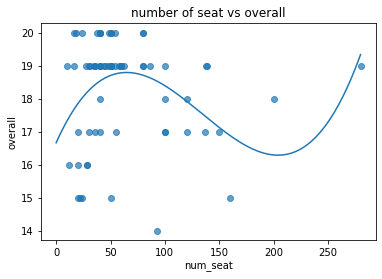

taste


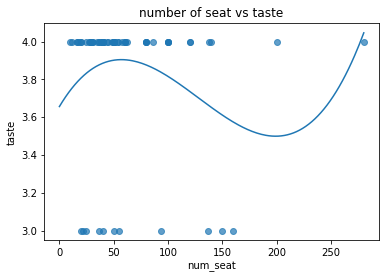

decor


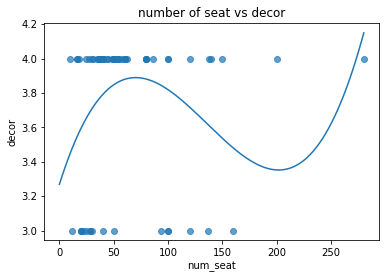

service


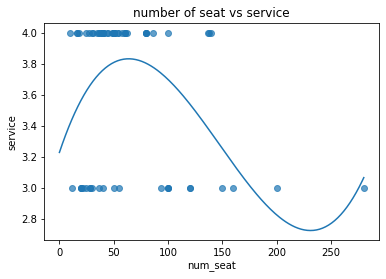

hygiene


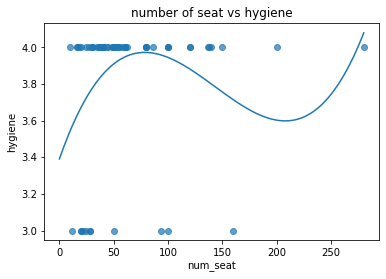

value


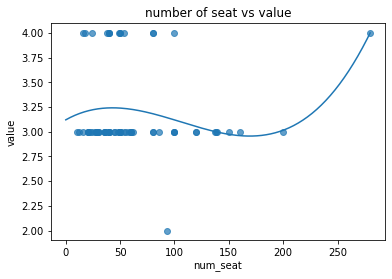

happy


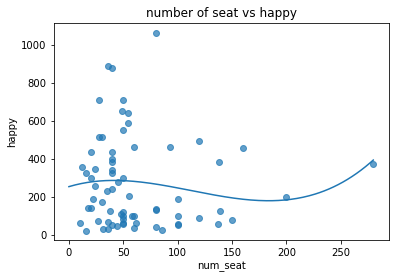

In [35]:
#analysis on effective number of seat can bring customer satisfaction
df_seat=df[df['num_seat'] != 0]
for i in ['overall','taste', 'decor', 'service',  'hygiene', 'value','happy']:
    print(i)
    title = 'number of seat vs '+i
    scatter_graph_2(df_seat['num_seat'],df_seat[i], title,280)
    

<h3> END

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")


sns.pairplot(df, hue="location")


In [ ]:
g = sns.jointplot(
    data=df,
    x="num_seat", y="overall", hue="price_int",
    kind="kde",
)

<AxesSubplot:xlabel='price_int', ylabel='overall'>

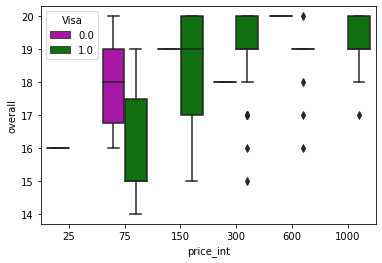

In [193]:
sns.boxplot(x="price_int", y="overall",
            hue="Visa", palette=["m", "g"],
            data=df)

In [ ]:
sns.boxplot(x="location", y="overall",
            hue="Alipay", palette=["m", "g"],
            data=df)

In [ ]:
#for i in ['taste', 'decor', 'service',  'hygiene', 'value','overall']: #num_facility

sns.boxplot(x="location", y="overall",
            hue="Master", palette=["m", "g"],
            data=df)

In [ ]:
density_graph("num_seat","overall",df)

In [ ]:
for i in Places:
    print(i)
    density_graph("happy","overall",df[df['location']==i])
#df[df['location']=="Central"].sort_values(by='happy', ascending = False)

In [ ]:
for i in df.iloc[:,11:16].columns:
    density_graph(i,"overall",df)

In [ ]:
df

taste
slope:  0.0002266551320522918


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


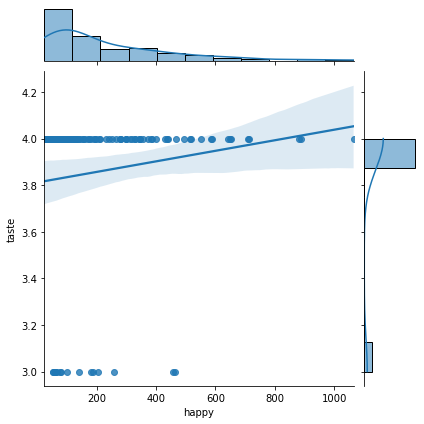

decor
slope:  -0.0004292794436630725


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


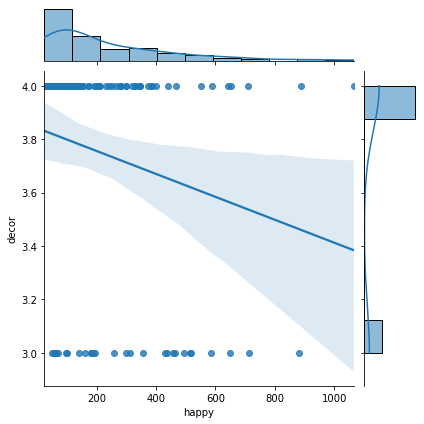

service
slope:  -0.00025182651225995047


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


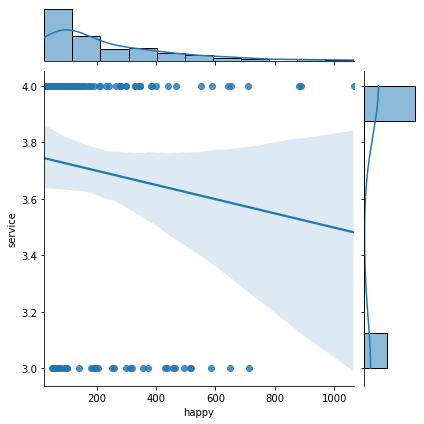

hygiene
slope:  -0.0003293677539422158


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


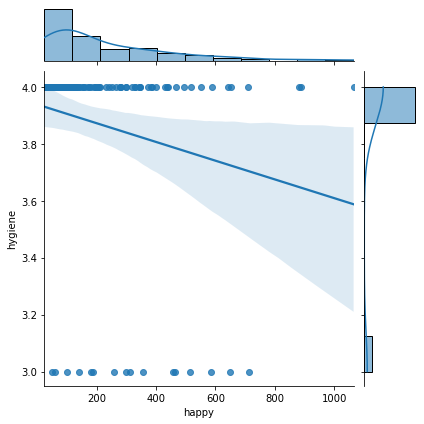

value
slope:  5.1853413320912916e-05


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


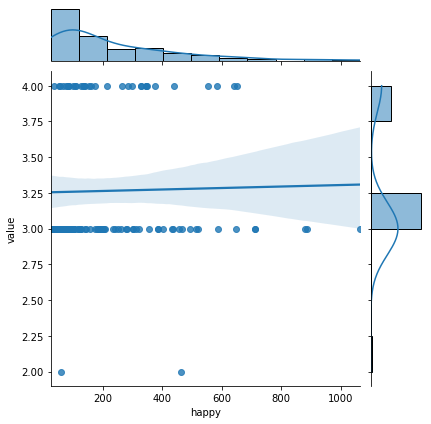

In [192]:
for i in ['taste', 'decor', 'service',  'hygiene', 'value']:
    print(i)
    m, b = np.polyfit(df['happy'], df[i], 1)
    print("slope: ",m)
    scatter_bar("happy",i,df)

In [ ]:
scatter_bar("AlipayHK",'value',df)

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
  
  
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
  
fig.suptitle('Overall')
  

sns.jointplot(data=df,x='overall', y='taste',  kind="reg",ax=axes[0,0])


In [ ]:
g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [ ]:
for i in ['taste', 'decor', 'service',  'hygiene', 'value']:
    m, b = np.polyfit(df['happy'], df[i], 1)
    print(i.upper(), "with slope:",m)
    sns.jointplot(x='overall', y='taste', data=df, kind="reg")
    plt.show()

taste
slope:  0.0002266551320522918


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


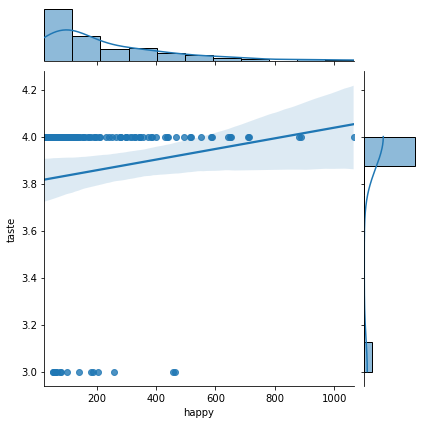

decor
slope:  -0.0004292794436630725


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


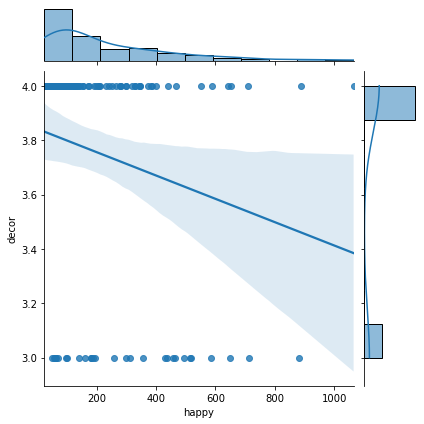

service
slope:  -0.00025182651225995047


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


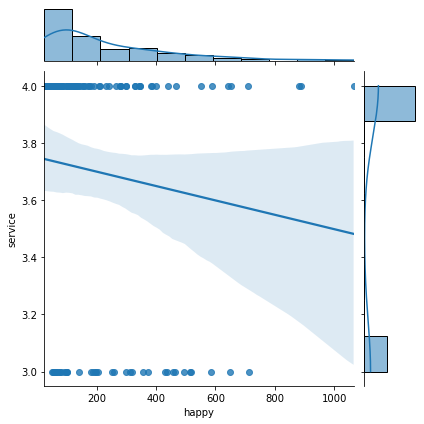

hygiene
slope:  -0.0003293677539422158


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


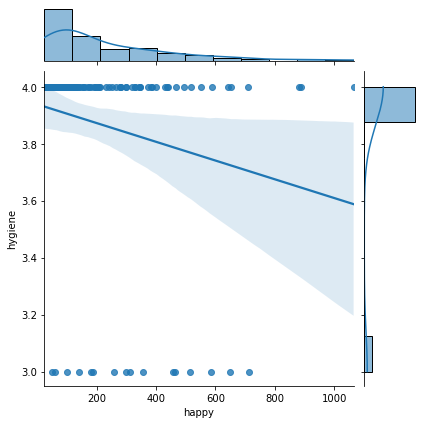

value
slope:  5.1853413320912916e-05


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


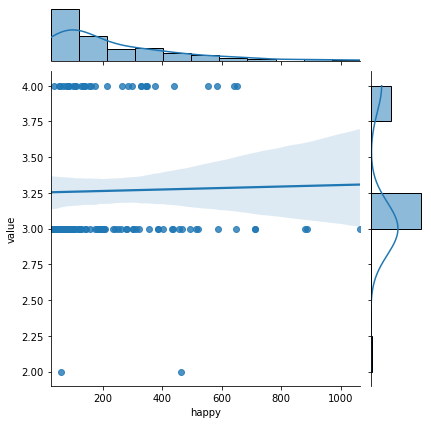

In [191]:
for i in ['taste', 'decor', 'service',  'hygiene', 'value']:
    print(i)
    m, b = np.polyfit(df['happy'], df[i], 1)
    print("slope: ",m)
    scatter_bar("happy",i,df)


In [ ]:
for i in ['taste', 'decor', 'service',  'hygiene', 'value']:
    print(i)
    m, b = np.polyfit(df['happy'], df[i], 1)
    print("slope: ",m)
    scatter_bar("bookmark",i,df)


In [ ]:
print("Table of correlation of various factors")
df.loc[:,['happy','sad','bookmark','taste', 'decor', 'service',  'hygiene','value','overall']].corr()

In [ ]:
df['overall'].mean()/5

In [ ]:
for i in ['taste', 'decor', 'service',  'hygiene','overall']:
    print(i)
    m, b = np.polyfit(df['overall'], df[i], 1)
    print("slope: ",m)
    scatter_bar("value",i,df)

overall


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


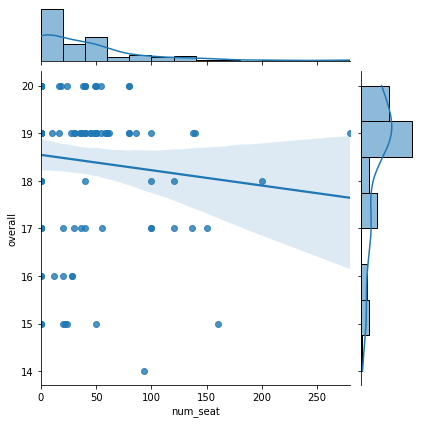

taste


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


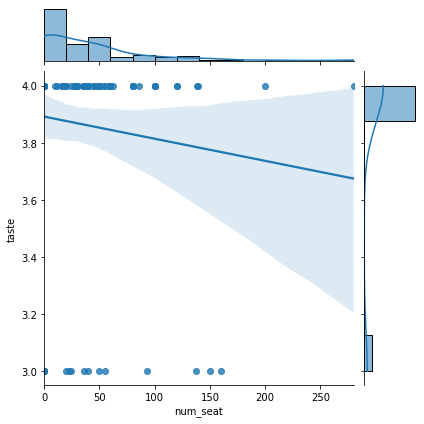

decor


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


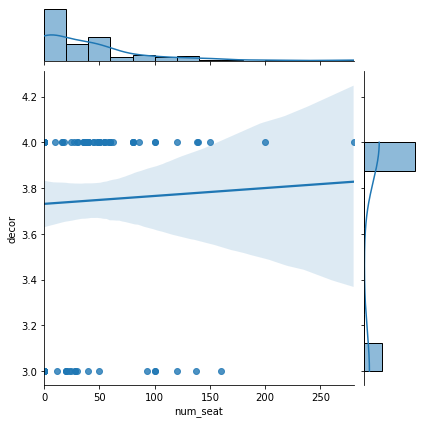

service


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


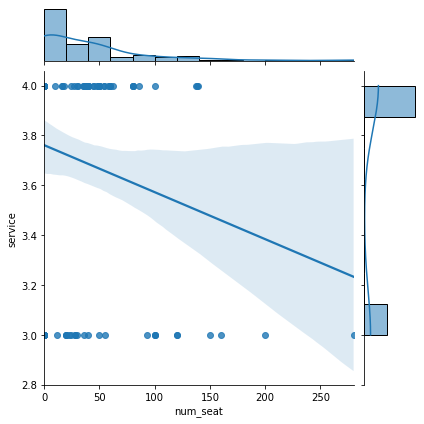

hygiene


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


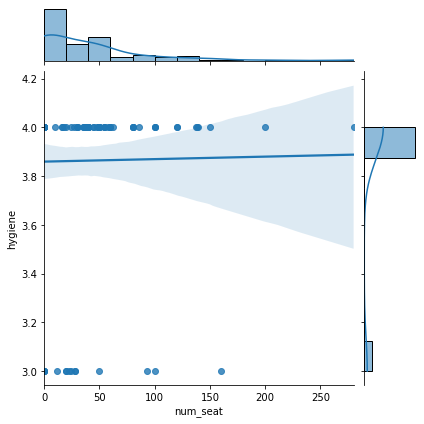

value


/Users/Jacky/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


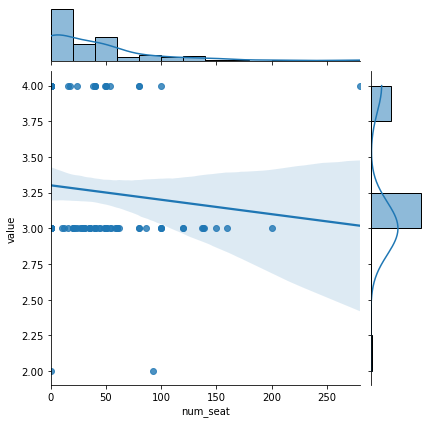

In [190]:
for i in ['overall','taste', 'decor', 'service',  'hygiene', 'value']:
    print(i)


    scatter_bar("num_seat",i,df[df['location']=="HK"]
               )

In [ ]:
for i in Places:
    print(i)
    scatter_bar("price_int","value",df[df['location']==i])

In [ ]:
sns.jointplot(
    data=df[df['location']=="Central"],
    x="overall", y="happy", hue="location_int",
    kind="kde"
)

In [ ]:
df.iloc[:,11:17]

In [ ]:
df

In [ ]:
sns.catplot(x="location_int", y="overall", hue="price_int", kind="box", data=df)

In [ ]:
for i in Places:
    print(i)
    pair_plot(df[df['location']==i],"price")


In [ ]:
#df['food_type'].unique()

In [ ]:
#top 200 restaurants ranked by happy
top_200 = df.sort_values('happy',ascending=False).iloc[0:200]
print("For top 200 restaurants: \n ------------------")
find_average(top_200)

In [ ]:
for i in Places:
    print("For {} \n------------------".format(i))
    find_average(df[df['location']==i])

In [ ]:
#Top 100 restaurant based on happy/sad ratio, group by prices
for i in Places:
    bar_chart(df[df['location']==i].sort_values("happy_vs_sad",ascending=False).iloc[0:100]['price'], "Price","{}: Graph of distirbution top 100 restaurants' prices based on ratio of happiness VS sadness".format(i), "Number of restaurants")

In [ ]:
#Group restaurants based on region and prices

for i in Places:
    bar_chart(df[df['location']==i]['price'], "Price","{}: Graph of distirbution of prices of restaurants".format(i), "Number of restaurants")

In [ ]:
#find average price in HK
for i in Places:
    print("Average price of a meal in {}:".format(i),df[df['location']==i]['price_int'].mean())

In [ ]:
#find average price of meal in area
for i in Places:
    lowest = 10000000
    highest = 0
    restaurant_low = "error"
    restaurant_high = "error"
    for k in restaurant_type:
        mean_price = df.loc[(df['food_type']==k) & (df['location']==i)]['price_int'].mean()
        if mean_price < lowest:
            restaurant_low = k
            lowest = mean_price
        if mean_price > highest:
            restaurant_high = k
            highest = mean_price
        print("Average price of a {} meal in {}:".format(k,i),mean_price)
    print("-------------------------")
    print("Cheapest food is: {} meal, costing {}".format(restaurant_low, lowest))
    print("Most expensive food is: {} meal, costing {}".format(restaurant_high, highest))
    print("-------------------------")
    print("")

In [ ]:
#Find relationship of bookmarks VS happy
for i in Places:
    scatter_graph(df.loc[(df['location']==i)]['bookmark'],df.loc[(df['location']==i)]['happy'],"Relationship between bookmark and happy in {}".format(i))

In [ ]:
visual = pd.plotting.scatter_matrix(df[['bookmark','happy','sad','price_int','happy_vs_sad']],c=df['food_int'],marker = 'o', s=5, hist_kwds={'bins':15}, figsize=(10,10))


In [ ]:
#maps color to legend
base_tags = pd.DataFrame({0,1,2,3,4,5,6,7,8,9})
#model.inverse_transform(base_tags)

plt.imshow([np.unique(df['food_int'])])
plt.xticks(ticks=np.unique(df['food_int']),labels=food_model.inverse_transform(base_tags))
#_ = plt.xticks(ticks=np.unique(df['food']),labels=model.inverse_transform(base_tags))